<a href="https://colab.research.google.com/github/nattrio/ANK-Corp/blob/master/Experiment_revised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiment

## Import Library

In [35]:
import warnings
warnings.filterwarnings('ignore')

# File
import os
from google.colab import drive
drive.mount('/content/drive')

# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Evaluation
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix

! pip install -q scikit-plot
import scikitplot as skplt

# Implementation
import pickle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# ติดตั้งภาษาไทย

!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

# !pip install -U --pre matplotlib  
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

## Import Dataset

In [37]:
dataset = pd.read_excel('/content/drive/Shared drives/D-Day_Project/วิเคราะห์ข้อมูล/Colab/Regression/BSCIT50-59 GRADES-BLINDED.xlsx')

In [38]:
dataset.shape

(599, 13)

In [39]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 13 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Yr                                       599 non-null    int64  
 1   Program                                  599 non-null    object 
 2   โครงการ                                  339 non-null    object 
 3   School GPAX                              599 non-null    float64
 4   คณิตศาสตร์                               238 non-null    float64
 5   วิทยาศาสตร์                              238 non-null    float64
 6   ภาษาต่างประเทศ                           309 non-null    float64
 7   คะแนนสอบสัมภาษณ์                         71 non-null     float64
 8   SIT GPAX in 1/59                         599 non-null    float64
 9   Predicted GPAX using all students model  599 non-null    float64
 10  สถานศึกษา                                599 non-n

## Exploratory Data Analysis

In [40]:
print(dataset['School GPAX'].min())
print(dataset['SIT GPAX in 1/59'].min())

1.97
1.18


In [41]:
sch_bins = list(np.arange(1.8, 4.1, 0.1))
sit_bins = list(np.arange(1.1, 4.1, 0.1))

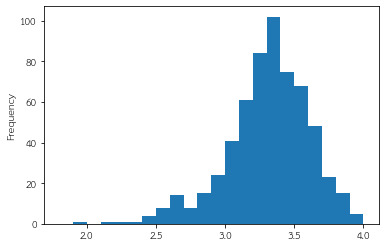

In [42]:
dataset['School GPAX'].plot.hist(bins=sch_bins)

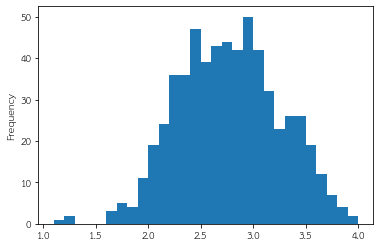

In [43]:
dataset['SIT GPAX in 1/59'].plot.hist(bins=sit_bins)

## Data Preprocessing

### Define function

In [44]:
def inputClass(score):
  if score >= 3.5:
    return 5
  elif score >= 3:
    return 4
  elif score >= 2.5:
    return 3
  elif score >= 2:
    return 2
  else:
    return 1

def outputClass(score):
  if score >= 3.5:
    return 5
  elif score >= 3:
    return 4
  elif score >= 2.5:
    return 3
  elif score >= 2:
    return 2
  else:
    return 1

### Drop rows

In [45]:
df = pd.DataFrame.copy(dataset)
df.shape

(599, 13)

In [46]:
# Drop null subject

df.dropna(subset=["ภาษาต่างประเทศ", "คณิตศาสตร์", "วิทยาศาสตร์"], inplace=True)
print(len(df))

238


In [47]:
# Drop Yr <= 51

print("Before:\t",df['Yr'].unique())
# df.drop(df[df['Yr'] <= 51].index, axis=0, inplace=True)
print("After:\t",df['Yr'].unique())
print(len(df))

Before:	 [59 58 57]
After:	 [59 58 57]
238


In [48]:
# หลังจาก drop แล้ว ให้เรียง index ใหม่

df.index = range(len(df))
df.shape

(238, 13)

In [49]:
# School GPAX to class

df["School_class"] = df["School GPAX"] # สร้าง column ใหม่ชื่อ School_class โดย copy จาก School GPAX

In [50]:
for i in range(len(df)):
  df["School_class"][i] = inputClass(df["School GPAX"][i])
df["School_class"] = pd.to_numeric(df["School_class"])

In [51]:
# School SIT to class

df["SIT_class"] = df["SIT GPAX in 1/59"]

for i in range(len(df)):
  df["SIT_class"][i] = outputClass(df["SIT GPAX in 1/59"][i])
df["SIT_class"] = pd.to_numeric(df["SIT_class"])

In [52]:
# Subject to class

df["math_class"] = df["คณิตศาสตร์"]
df["sci_class"] = df["วิทยาศาสตร์"]
df["eng_class"] = df["ภาษาต่างประเทศ"]

for i in range(len(df)):
  df["math_class"][i] = inputClass(df["คณิตศาสตร์"][i])
df["math_class"] = pd.to_numeric(df["math_class"])

for i in range(len(df)):
  df["sci_class"][i] = inputClass(df["วิทยาศาสตร์"][i])
df["sci_class"] = pd.to_numeric(df["sci_class"])

for i in range(len(df)):
  df["eng_class"][i] = inputClass(df["ภาษาต่างประเทศ"][i])
df["eng_class"] = pd.to_numeric(df["eng_class"])

In [53]:
df.head()

,Yr,Program,โครงการ,School GPAX,คณิตศาสตร์,วิทยาศาสตร์,ภาษาต่างประเทศ,คะแนนสอบสัมภาษณ์,SIT GPAX in 1/59,Predicted GPAX using all students model,สถานศึกษา,จังหวัดสถานศึกษา,เขตสถานศึกษา,School_class,SIT_class,math_class,sci_class,eng_class
0,59,BScIT,เรียนดี,3.64,3.67,3.66,3.47,NaN,3.06,2.89712,S002-0,กรุงเทพมหานคร,หนองแขม,5.0,4.0,5.0,5.0,4.0
1,59,BScIT,เรียนดี,3.40,3.45,3.41,3.30,NaN,2.25,2.79320,S002-0,กรุงเทพมหานคร,หนองแขม,4.0,2.0,4.0,4.0,4.0
2,58,BScIT,Clearing House,3.39,3.22,3.28,3.38,NaN,2.16,2.78887,S002-0,กรุงเทพมหานคร,หนองแขม,4.0,2.0,4.0,4.0,4.0
3,58,BScIT,เรียนดี,3.30,3.30,3.14,3.27,NaN,1.95,2.74990,S002-0,กรุงเทพมหานคร,หนองแขม,4.0,1.0,4.0,4.0,4.0
4,58,BScIT,GAT/PAT,3.48,2.54,3.81,3.17,NaN,2.99,2.82784,S004-0,กรุงเทพมหานคร,บางรัก,4.0,3.0,3.0,5.0,4.0


### Splitting Data

In [54]:
# X = np.array(df[['School_class', 
#                  "math_class", 
#                  "eng_class", 
#                  "sci_class"
#                  ]]) 
X = np.array(df[['School GPAX', 
                 "คณิตศาสตร์", 
                 "วิทยาศาสตร์", 
                 "ภาษาต่างประเทศ"
                 ]])

# X = np.array(df[['School GPAX']]) # .reshape(1,-1)
y = np.array(df['SIT GPAX in 1/59'])
y_class = np.array(df['SIT_class'])

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y_class , train_size=0.8) # train size 0.8 คือ แบ่งไว้เทรน 80%

In [56]:
print("All:", len(X))
print("Train: {}, Test: {}".format(len(X_train),len(X_test)))

All: 238
Train: 190, Test: 48


## Evaluation

### Acceptance

In [57]:
def acceptance(matrix, n):
  i = n-1
  if n == 1:
    score = matrix[i][i] + matrix[i+1][i]
  elif n == len(matrix):
    score = matrix[i-1][i] + matrix[i][i]
  else:
    score = matrix[i-1][i] + matrix[i][i] + matrix[i+1][i]
  return score

In [58]:
def nan_to_zero(n):
  if np.isnan(n):
    return 0
  else:
    return n

In [59]:
def eval_predict(array):
  temp = np.asmatrix(array).transpose()
  matrix = np.array(temp)
  for i in range(len(matrix)):
    class_num = i+1
    print("Predict {} ({})".format(class_num, matrix[i].sum()))
    for n in range(len(matrix[i])):
      pred_num = n+1
      score = matrix[i][n]
      # print(" - Actual Class {}: {}".format(pred_num, score))
      if i==n:
        print(" - Accuracy:\t{}\t({:.0%})".format(score, nan_to_zero(score/matrix[i].sum())))
    acp = acceptance(array, class_num)
    print(" - Acceptable:\t{}\t({:.0%})".format(nan_to_zero(acp), nan_to_zero(acp/matrix[i].sum())))
    print(" - Missed:\t{}\t({:.0%})".format(matrix[i].sum() - acp, 1 - nan_to_zero(acp/matrix[i].sum())))

### K-fold

In [60]:
def kfold_eval(n_splits,model):
  model_score = []
  pred_all = np.array(())
  cv = KFold(n_splits)

  for train_index, test_index in cv.split(X):
    X_train_k, y_train_k = X[train_index], y_class[train_index]
    X_test_k, y_test_k   = X[test_index], y_class[test_index]

    print("test index: {}-{}".format(test_index[0], test_index[-1]))

    model.fit(X_train_k,y_train_k)
    pred = model.predict(X_test_k)
    accur = accuracy_score(y_test_k,pred)
    
    model_score.append(accur)
    pred_all = np.concatenate((pred_all, pred), axis=None)
  show_score(model_score)
  # pred_all = pred_all.astype(int)
  eval_predict(confusion_matrix(y_class, pred_all))
  skplt.metrics.plot_confusion_matrix(y_class, pred_all)

In [61]:
def show_score(score):
  print("--------------------")
  print("Mean:\t",np.mean(score))
  print("Max:\t",np.max(score))
  print("Min:\t",np.min(score))
  print("S.D.:\t",np.std(score))
  print(score,"\n")

## Modelling

### KNeighborsClassifier

test index: 0-47
test index: 48-95
test index: 96-143
test index: 144-190
test index: 191-237
--------------------
Mean:	 0.2854609929078014
Max:	 0.3617021276595745
Min:	 0.14893617021276595
S.D.:	 0.07441582512762376
[0.3333333333333333, 0.2708333333333333, 0.3125, 0.14893617021276595, 0.3617021276595745] 

Predict 1 (8)
 - Accuracy:	0	(0%)
 - Acceptable:	3	(38%)
 - Missed:	5	(62%)
Predict 2 (83)
 - Accuracy:	25	(30%)
 - Acceptable:	61	(73%)
 - Missed:	22	(27%)
Predict 3 (93)
 - Accuracy:	25	(27%)
 - Acceptable:	77	(83%)
 - Missed:	16	(17%)
Predict 4 (48)
 - Accuracy:	18	(38%)
 - Acceptable:	40	(83%)
 - Missed:	8	(17%)
Predict 5 (6)
 - Accuracy:	0	(0%)
 - Acceptable:	4	(67%)
 - Missed:	2	(33%)


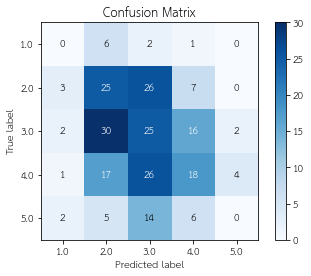

In [62]:
KNN = KNeighborsClassifier()
kfold_eval(5,KNN)

### RandomForestClassifier

test index: 0-47
test index: 48-95
test index: 96-143
test index: 144-190
test index: 191-237
--------------------
Mean:	 0.29406028368794324
Max:	 0.3541666666666667
Min:	 0.25
S.D.:	 0.039217677853546316
[0.2916666666666667, 0.25, 0.3541666666666667, 0.2553191489361702, 0.3191489361702128] 

Predict 1 (7)
 - Accuracy:	0	(0%)
 - Acceptable:	3	(43%)
 - Missed:	4	(57%)
Predict 2 (66)
 - Accuracy:	21	(32%)
 - Acceptable:	50	(76%)
 - Missed:	16	(24%)
Predict 3 (80)
 - Accuracy:	28	(35%)
 - Acceptable:	68	(85%)
 - Missed:	12	(15%)
Predict 4 (70)
 - Accuracy:	20	(29%)
 - Acceptable:	51	(73%)
 - Missed:	19	(27%)
Predict 5 (15)
 - Accuracy:	1	(7%)
 - Acceptable:	11	(73%)
 - Missed:	4	(27%)


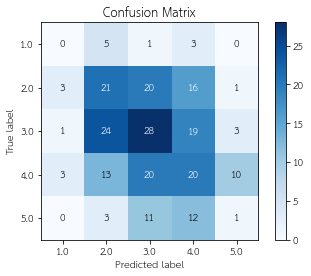

In [63]:
RFC = RandomForestClassifier()
kfold_eval(5,RFC)

### LogisticRegression

test index: 0-47
test index: 48-95
test index: 96-143
test index: 144-190
test index: 191-237
--------------------
Mean:	 0.3234929078014185
Max:	 0.3617021276595745
Min:	 0.2765957446808511
S.D.:	 0.03379322853255052
[0.3333333333333333, 0.3541666666666667, 0.2916666666666667, 0.3617021276595745, 0.2765957446808511] 

Predict 1 (0)
 - Accuracy:	0	(0%)
 - Acceptable:	0	(0%)
 - Missed:	0	(100%)
Predict 2 (58)
 - Accuracy:	21	(36%)
 - Acceptable:	44	(76%)
 - Missed:	14	(24%)
Predict 3 (87)
 - Accuracy:	25	(29%)
 - Acceptable:	76	(87%)
 - Missed:	11	(13%)
Predict 4 (93)
 - Accuracy:	31	(33%)
 - Acceptable:	80	(86%)
 - Missed:	13	(14%)
Predict 5 (0)
 - Accuracy:	0	(0%)
 - Acceptable:	0	(0%)
 - Missed:	0	(100%)


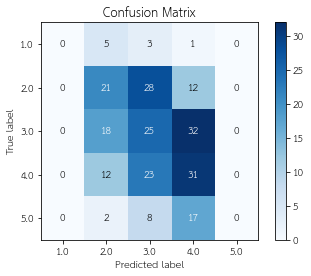

In [64]:
LG  = LogisticRegression()
kfold_eval(5,LG)

### DecisionTreeClassifier

test index: 0-47
test index: 48-95
test index: 96-143
test index: 144-190
test index: 191-237
--------------------
Mean:	 0.27296099290780146
Max:	 0.3125
Min:	 0.23404255319148937
S.D.:	 0.024900776384564737
[0.2708333333333333, 0.2708333333333333, 0.3125, 0.23404255319148937, 0.2765957446808511] 

Predict 1 (12)
 - Accuracy:	0	(0%)
 - Acceptable:	5	(42%)
 - Missed:	7	(58%)
Predict 2 (65)
 - Accuracy:	18	(28%)
 - Acceptable:	49	(75%)
 - Missed:	16	(25%)
Predict 3 (85)
 - Accuracy:	27	(32%)
 - Acceptable:	69	(81%)
 - Missed:	16	(19%)
Predict 4 (49)
 - Accuracy:	18	(37%)
 - Acceptable:	34	(69%)
 - Missed:	15	(31%)
Predict 5 (27)
 - Accuracy:	2	(7%)
 - Acceptable:	13	(48%)
 - Missed:	14	(52%)


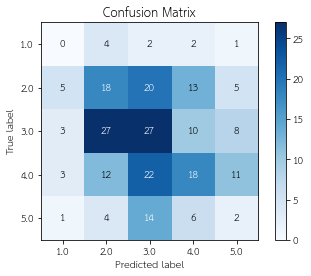

In [65]:
DTC = DecisionTreeClassifier()
kfold_eval(5,DTC)

### MLPClassifier

test index: 0-47
test index: 48-95
test index: 96-143
test index: 144-190
test index: 191-237
--------------------
Mean:	 0.2517730496453901
Max:	 0.3125
Min:	 0.2127659574468085
S.D.:	 0.03767574047648815
[0.25, 0.2708333333333333, 0.3125, 0.2127659574468085, 0.2127659574468085] 

Predict 1 (0)
 - Accuracy:	0	(0%)
 - Acceptable:	0	(0%)
 - Missed:	0	(100%)
Predict 2 (5)
 - Accuracy:	4	(80%)
 - Acceptable:	5	(100%)
 - Missed:	0	(0%)
Predict 3 (133)
 - Accuracy:	34	(26%)
 - Acceptable:	111	(83%)
 - Missed:	22	(17%)
Predict 4 (100)
 - Accuracy:	22	(22%)
 - Acceptable:	75	(75%)
 - Missed:	25	(25%)
Predict 5 (0)
 - Accuracy:	0	(0%)
 - Acceptable:	0	(0%)
 - Missed:	0	(100%)


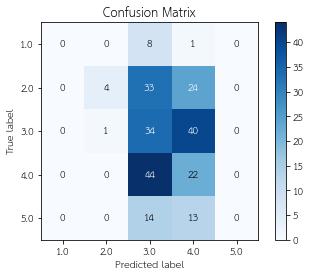

In [66]:
MLP = MLPClassifier()
kfold_eval(5,MLP)

### LinearRegression

test index: 0-47
test index: 48-95
test index: 96-143
test index: 144-190
test index: 191-237
--------------------
Mean:	 0.3405141843971631
Max:	 0.5319148936170213
Min:	 0.19148936170212766
S.D.:	 0.1092982644332393
[0.3333333333333333, 0.3333333333333333, 0.3125, 0.5319148936170213, 0.19148936170212766] 

Predict 1 (0)
 - Accuracy:	0	(0%)
 - Acceptable:	0	(0%)
 - Missed:	0	(100%)
Predict 2 (19)
 - Accuracy:	7	(37%)
 - Acceptable:	16	(84%)
 - Missed:	3	(16%)
Predict 3 (179)
 - Accuracy:	57	(32%)
 - Acceptable:	154	(86%)
 - Missed:	25	(14%)
Predict 4 (40)
 - Accuracy:	17	(42%)
 - Acceptable:	36	(90%)
 - Missed:	4	(10%)
Predict 5 (0)
 - Accuracy:	0	(0%)
 - Acceptable:	0	(0%)
 - Missed:	0	(100%)


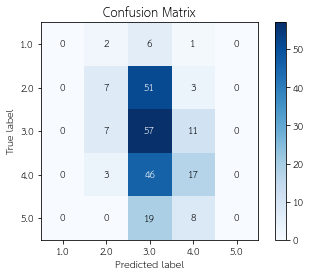

In [67]:
LR  = LinearRegression()
lr_score = []
pred_all = np.array(())
cv = KFold(5)

for train_index, test_index in cv.split(X):
    X_train_k, y_train_k = X[train_index], y_class[train_index]
    X_test_k, y_test_k   = X[test_index], y_class[test_index]

    y_train_c, y_test_c = y[train_index], y[test_index]

    print("test index: {}-{}".format(test_index[0], test_index[-1]))

    LR.fit(X_train_k,y_train_c)
    pred = LR.predict(X_test_k)
    for i in range(len(pred)):
      pred[i] = outputClass(pred[i])

    accur = accuracy_score(y_test_k,pred)
    lr_score.append(accur)
    pred_all = np.concatenate((pred_all, pred), axis=None)
show_score(lr_score)
eval_predict(confusion_matrix(y_class, pred_all))
skplt.metrics.plot_confusion_matrix(y_class, pred_all)

### LinearRegression 100

test index: 0-47
test index: 48-95
test index: 96-143
test index: 144-190
test index: 191-237
--------------------
Mean:	 0.3320035460992908
Max:	 0.5319148936170213
Min:	 0.14893617021276595
S.D.:	 0.1215418742318513
[0.3333333333333333, 0.3333333333333333, 0.3125, 0.5319148936170213, 0.14893617021276595] 

Predict 1 (0)
 - Accuracy:	0	(0%)
 - Acceptable:	0	(0%)
 - Missed:	0	(100%)
Predict 2 (21)
 - Accuracy:	8	(38%)
 - Acceptable:	18	(86%)
 - Missed:	3	(14%)
Predict 3 (177)
 - Accuracy:	54	(31%)
 - Acceptable:	153	(86%)
 - Missed:	24	(14%)
Predict 4 (40)
 - Accuracy:	17	(42%)
 - Acceptable:	40	(100%)
 - Missed:	0	(0%)
Predict 5 (0)
 - Accuracy:	0	(0%)
 - Acceptable:	0	(0%)
 - Missed:	0	(100%)


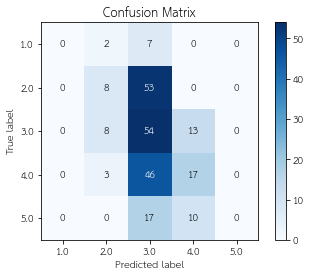

In [68]:
LR  = LinearRegression()
lr100_score = []
pred_all = np.array(())
cv = KFold(5)

for train_index, test_index in cv.split(X):
    X_train_k, y_train_k = X[train_index], y_class[train_index]
    X_test_k, y_test_k   = X[test_index], y_class[test_index]

    print("test index: {}-{}".format(test_index[0], test_index[-1]))

    LR.fit(X,y)
    pred = LR.predict(X_test_k)
    for i in range(len(pred)):
      pred[i] = outputClass(pred[i])

    accur = accuracy_score(y_test_k,pred)
    lr100_score.append(accur)
    pred_all = np.concatenate((pred_all, pred), axis=None)
show_score(lr100_score)
eval_predict(confusion_matrix(y_class, pred_all))
skplt.metrics.plot_confusion_matrix(y_class, pred_all)

## Summary